In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
import pywt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer 
from sklearn.impute import SimpleImputer

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf







In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

zsh:1: command not found: dpkg
zsh:1: command not found: pip


In [175]:
# Set return period
return_period = 5
#load data from csv files
#stocks 
baba_data = pd.read_csv('BABA.csv')
goog_data = pd.read_csv('GOOGL.csv')
amzn_data = pd.read_csv('AMZN.csv')
msft_data = pd.read_csv('MSFT.csv')

#ETFs
skyy_data = pd.read_csv('SKYY.csv')

# indices 
vix_data = pd.read_csv('^VIX.csv')
ixic_data = pd.read_csv('^IXIC.csv')

#Target data (ETF)
ivw_data = pd.read_csv('IVW.csv') 

feature_list = []

Y = np.log(ivw_data.loc[:, 'Adj Close']).diff(return_period).shift(-return_period)
Y.name = 'IVW_pred'
feature_list.append(Y)

stocks_list = [baba_data, goog_data, amzn_data,skyy_data, vix_data, ixic_data,msft_data]
stk_tickers = ['BABA','GOOGL','AMZN','SKYY','VIX','IXIC','MSFT']

for i in range(len(stocks_list)):
    data = stocks_list[i]
    X = np.log(data.loc[:, 'Adj Close']).diff(return_period).shift(-return_period)
    X.name = stk_tickers[i]
    feature_list.append(X)


for i in [return_period, return_period*3, return_period*6, return_period*12]:
    X = np.log(ivw_data.loc[:,'Adj Close']).diff(i)
    X.name = 'IVW_'+str(int(i/return_period))+'DT'
    feature_list.append(X)

dataset = pd.concat(feature_list, axis=1).dropna().iloc[::return_period, :]
dataset = dataset.append(dataset.iloc[-2:])
# print(dataset.iloc[-1])
Y = dataset.loc[:, dataset.columns[0:1]]
X = dataset.loc[:, dataset.columns[2:]]
pd.set_option('precision', 3)

In [176]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
IXIC,5350.260
SKYY,1187.358
VIX,695.849
MSFT,334.943
GOOGL,302.346
IVW_6DT,8.292
IVW_12DT,6.172
IVW_3DT,5.186
IVW_1DT,4.133


In [177]:
# train test split
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
#select the samples
x_train = X.iloc[0:300]
x_test = X.iloc[300:]

y_train = Y.iloc[0:300]
y_test = Y.iloc[300:]

# Model testing

In [178]:
num_folds = 10
seed = 7

# x_train = X.iloc[0:300]
# x_test = X.iloc[300:]

# y_train = Y.iloc[0:300]
# y_test = Y.iloc[300:]

# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RIDGE', Ridge()))
# models.append(('SVR', SVR()))
# models.append(('MLP', MLPRegressor()))
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
# models.append(('RFR', RandomForestRegressor()))
# models.append(('ETR', ExtraTreesRegressor()))

models.append(('BYS',linear_model.BayesianRidge()))

names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, shuffle=True,random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(x_train, y_train)
    train_result = mean_squared_error(res.predict(x_train), y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(x_test), y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000018 (0.000005) 0.000016 0.000026
LASSO: 0.000307 (0.000193) 0.000305 0.000412
EN: 0.000307 (0.000193) 0.000305 0.000412
KNN: 0.000092 (0.000081) 0.000056 0.000123
RIDGE: 0.000078 (0.000028) 0.000072 0.000134
ABR: 0.000044 (0.000056) 0.000015 0.000031
GBR: 0.000038 (0.000051) 0.000003 0.000035
BYS: 0.000018 (0.000005) 0.000016 0.000027


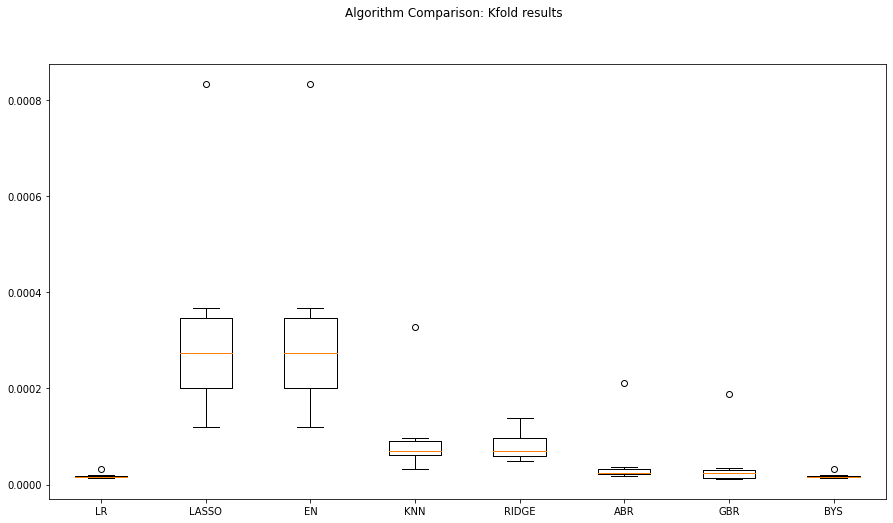

In [179]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

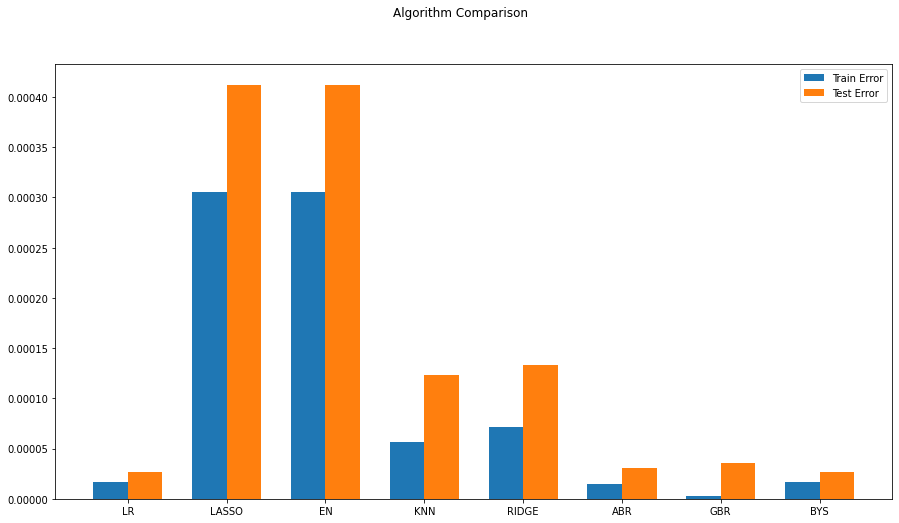

In [180]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

# LSTM model

In [181]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(y_train)[seq_len-1:], np.array(y_test)
X_train_LSTM = np.zeros((x_train.shape[0]+1-seq_len, seq_len, x_train.shape[1]))
X_test_LSTM = np.zeros((x_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(x_train)[i:x_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[x_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [182]:
# Lstm Network
def create_LSTMmodel(neurons, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=370, batch_size=72, verbose=0, shuffle=False)

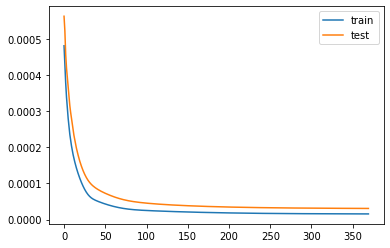

In [183]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [184]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(y_test,predicted)
error_Test_LSTM

3.086789907975272e-05

Append to previous result

In [185]:
test_results.append(error_Test_LSTM)
train_results.append(error_Training_LSTM)
names.append("LSTM")

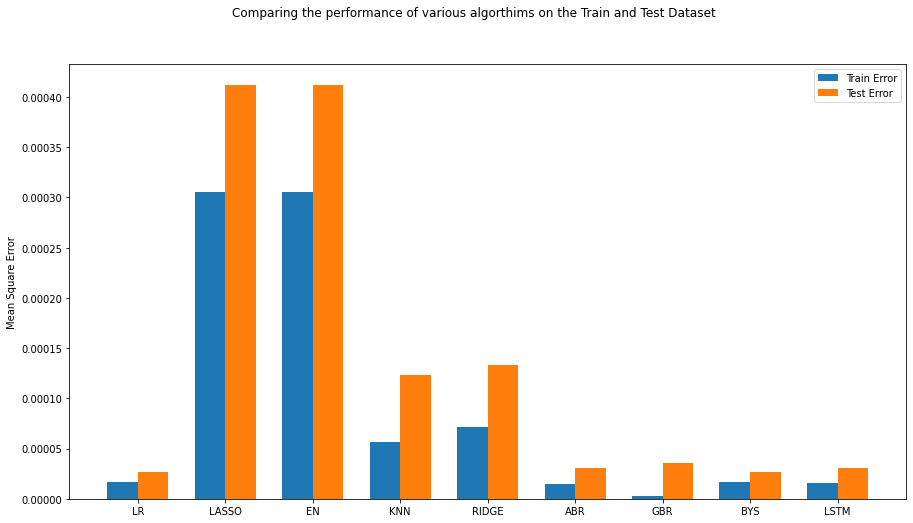

In [186]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.savefig("algo_compare_error.png")
pyplot.show()

In [187]:
def sharpe(y_true, y_pred):
    positions = np.where(y_pred> 0,1,-1 )
    dailyRet = pd.Series(positions).shift(1).fillna(0).values * y_true
    dailyRet = np.nan_to_num(dailyRet)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
    return ratio
myscorer = make_scorer(sharpe, greater_is_better=True)

In [188]:
import talib as ta
#build talib features
def add_indicators(df):
    res_df = df
    res_df['SMA'] = ta.SMA(df.Close.values)
    return res_df
    
#for optimizing the timeperiod of RSI and ADX
def RSI_ADX_optimizer(x, timeperiod=None):
    df = ivw_data.iloc[x.index.values]
    df = pd.DataFrame(df, columns=['Open','High','Low','RSI', 'ADX'])
    x['RSI'] =ta.RSI(np.array(df['Open']), timeperiod=timeperiod)
    x['ADX'] = ta.ADX(np.array(df['High']),np.array(df['Low']), np.array(df['Open']), timeperiod=timeperiod)
    x=x.fillna(0)
    return x
ivw_data_inidis = add_indicators(ivw_data)

In [189]:
def wavelet_smoother(x_train, scale=None):
        wavelet = "db6"
        x_train = pd.DataFrame(x_train)
        df_wavelets = x_train.copy()

        for i in x_train.columns:
            signal = x_train[i]
            coefficients = pywt.wavedec(signal, wavelet, mode='per')
            coefficients[1:] = [pywt.threshold(i, value=scale*signal.max(), mode='soft')
                                for i in coefficients[1:]]
            reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
            df_wavelets[i] = reconstructed_signal
            
        df_wavelets = df_wavelets.fillna(0)
        return df_wavelets
    


In [190]:
scaler = StandardScaler()

rsiadx = FunctionTransformer(RSI_ADX_optimizer)
waveletsmoother = FunctionTransformer(wavelet_smoother)
extractor = PCA()

bys = linear_model.BayesianRidge()
timeperiod_rs = [{'timeperiod': 5},{'timeperiod': 10}]
scales_rs = [{'scale': 0.1},{'scale': 0.3}]
a_rs = np.linspace(0.001, 1, num=20, endpoint=True)
n_components_rs = [2,3,4,5,6,7,8,9,10,11,12,13]

pipe = Pipeline([('scaler',scaler),("smoother", waveletsmoother),('talib',rsiadx),
                 ('pca',extractor),("model", bys)])
param_grid = [{'smoother__kw_args': scales_rs, 'talib__kw_args':timeperiod_rs,
               'pca__n_components': n_components_rs, 'model__alpha_1': a_rs,'model__lambda_1':a_rs}]

split = TimeSeriesSplit(n_splits = 5, max_train_size = 2000)
grid_search = RandomizedSearchCV(pipe, param_grid, cv=split, scoring=myscorer, return_train_score=True)
grid_search.fit(x_train.values, y_train.values.ravel())
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters scaling grid: {}".format(best_parameters))
print("Best cross-validation score scaling grid: {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)


Best parameters scaling grid: {'talib__kw_args': {'timeperiod': 5}, 'smoother__kw_args': {'scale': 0.3}, 'pca__n_components': 12, 'model__lambda_1': 0.8422631578947368, 'model__alpha_1': 0.6319473684210526}
Best cross-validation score scaling grid: 311.64


train error: 8.03376456025409e-05
test error: 0.00012220371996507536


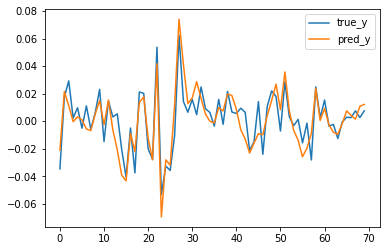

In [191]:
true_y = y_test.values.ravel()
pred_y = best_model.predict(x_test.values)

train_result = mean_squared_error(best_model.predict(x_train.values), y_train.values.ravel())
test_result = mean_squared_error(true_y, pred_y)
print('train error:',train_result)
print('test error:',test_result)

from matplotlib import pyplot
pyplot.plot(true_y, label='true_y')
pyplot.plot(pred_y, label='pred_y')
pyplot.legend()
pyplot.savefig("trueypredy.png")
pyplot.show()

In-sample: CAGR=-0.00861109 Sharpe ratio=-0.00649672 maxDD=-0.375734 maxDDD=256 Calmar ratio=-0.022918 Rho=0.815813 PVal=7.88181e-18

average return 0.344135
[-0.39092433  0.39203901]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.04400000000000004


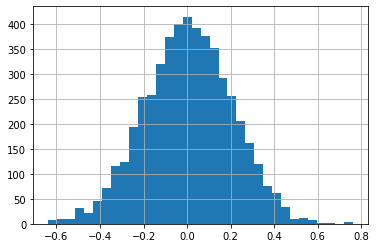

In [192]:
import fAux
positions = np.where(grid_search.predict(x_train.values)> 0,1,-1 ) 
dailyRet = pd.Series(positions).shift(5).fillna(0).values * y_train['IVW_pred']
dailyRet = dailyRet.fillna(0)
cumret = np.array(np.cumprod(dailyRet + 1) - 1)

rho, pval = spearmanr(y_test,grid_search.predict(x_test.values)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret[-1]) ** ((253/5) / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = ((253/5) ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6} Rho={:0.6} PVal={:0.6}\n'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


from sklearn.metrics import accuracy_score
import WhiteRealityCheckFor1
import detrendPrice
#white reality check

new_close = ivw_data.iloc[X.index.values]['Adj Close'].reset_index(drop= True)[(x_train.shape[0]):,]
detrended_close = detrendPrice.detrendPrice(new_close)
detrended_ret1 = detrended_close.diff(5).shift(-5).fillna(0)
detrended_syst_rets = detrended_ret1 * pd.Series(positions).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
pyplot.savefig("white.png")
pyplot.show()


In [193]:
positions2 = np.where(grid_search.predict(x_test.values)> 0,1,-1 )
dailyRet2 = pd.Series(positions2).shift(5).fillna(0).values * y_test['IVW_pred']
dailyRet2 = dailyRet2.fillna(0)
cumret2 = np.array(np.cumprod(dailyRet2 + 1) - 1)

rho, pval = spearmanr(y_test,grid_search.predict(x_test.values)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret2[-1]) ** ((253/5) / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = ((253/5) ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))



Out-of-sample: CAGR=-0.0758522 Sharpe ratio=-0.502647 maxDD=-0.169488 maxDDD=23 Calmar ratio=-0.447537  Rho=0.815813 PVal=7.88181e-18



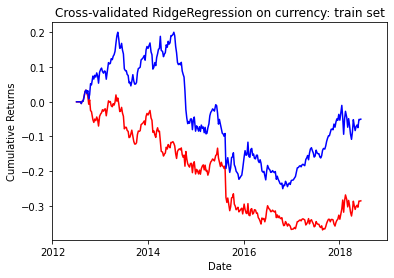

In [194]:
import matplotlib.dates as mdates
from datetime import datetime

positionsytrain = np.where(y_train.values.ravel() > 0,1,-1 )
dailyRetytrain = pd.Series(positionsytrain).shift(5).fillna(0).values * y_train['IVW_pred']
dailyRetytrain = dailyRetytrain.fillna(0)
cumretytrain = np.array(np.cumprod(dailyRetytrain + 1) - 1)

df = ivw_data
dates = ivw_data.iloc[X.index.values]['Date']
dates= dates.reset_index(drop= True)[:x_train.shape[0],]

#x axis date formating
datesformat=[0 for _ in range(300)]
for i in range(300):
    datesformat[i] = pd.to_datetime(dates[i], format='%Y-%m-%d')
    
pyplot.figure(1)
pyplot.plot(datesformat, cumretytrain ,'r')
pyplot.plot(datesformat, cumret,'b')
    
myFmt = mdates.DateFormatter('%Y')
years = mdates.YearLocator(2)
months = mdates.MonthLocator()
pyplot.gca().xaxis.set_major_locator(years)
pyplot.gca().xaxis.set_major_formatter(myFmt)
datemin = np.datetime64('2012-01-01', 'Y')
datemax = np.datetime64('2019-01-01', 'Y')
pyplot.gca().set_xlim(datemin, datemax)

# plt.show()
pyplot.title('Cross-validated RidgeRegression on currency: train set')
pyplot.ylabel('Cumulative Returns')
pyplot.xlabel('Date')
pyplot.savefig("cross_train.png")

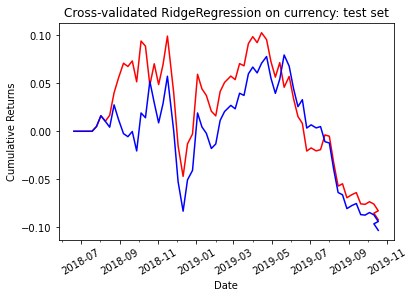

In [195]:
positionsytest = np.where(y_test.values.ravel() > 0,1,-1 )
dailyRetytest = pd.Series(positionsytest).shift(5).fillna(0).values * y_test['IVW_pred']
dailyRetytest = dailyRetytest.fillna(0)
cumretytest = np.array(np.cumprod(dailyRetytest + 1) - 1)

dates= df.iloc[X.index.values]['Date']
dates= dates.reset_index(drop= True)[x_train.shape[0]:,]

#x axis date formating
datesformat=[0 for _ in range(70)]
for i in range(70):
    datesformat[i] = pd.to_datetime(dates[i + 300], format='%Y-%m-%d')

pyplot.plot(datesformat, cumretytest ,'r')
pyplot.plot(datesformat, cumret2,'b')
    
myFmt = mdates.DateFormatter('%Y-%m')
years = mdates.YearLocator()
months = mdates.MonthLocator()
pyplot.gca().xaxis.set_major_formatter(myFmt)
pyplot.gca().xaxis.set_minor_locator(months)
pyplot.xticks(rotation=30)

pyplot.title('Cross-validated RidgeRegression on currency: test set')
pyplot.ylabel('Cumulative Returns')
pyplot.xlabel('Date')
pyplot.savefig("cross_test.png")

In [197]:
# abr model tunning
abr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

pipe = Pipeline([('scaler',scaler),("smoother", waveletsmoother),('talib',rsiadx),('pca',extractor), ("model", abr)])
param_grid = [{'smoother__kw_args': scales_rs,'talib__kw_args':timeperiod_rs,'pca__n_components': n_components_rs, 
               'model__n_estimators':[5,10,20],'model__learning_rate':[0.01,0.1],
              'model__base_estimator__min_samples_leaf':[5,10],
               'model__base_estimator__max_depth':[i for i in range(2,11,2)]}]

# pipe = Pipeline([("smoother", smoother), ("model", abr)])
# param_grid = [{'smoother__kw_args': spans_rs, 'model__n_estimators':[5,10,20],
#                'model__learning_rate':[0.01,0.1],'model__base_estimator__min_samples_leaf':[5,10],
#                'model__base_estimator__max_depth':[i for i in range(2,11,2)]}]


In [198]:
# parameters tunning
split = TimeSeriesSplit(n_splits = 5, max_train_size = 2000)
grid_search = RandomizedSearchCV(pipe, param_grid, cv=split, scoring=myscorer, return_train_score=True)
grid_search.fit(x_train.values, y_train.values.ravel())
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters scaling grid: {}".format(best_parameters))
print("Best cross-validation score scaling grid: {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

Best parameters scaling grid: {'talib__kw_args': {'timeperiod': 5}, 'smoother__kw_args': {'scale': 0.3}, 'pca__n_components': 4, 'model__n_estimators': 5, 'model__learning_rate': 0.01, 'model__base_estimator__min_samples_leaf': 5, 'model__base_estimator__max_depth': 2}
Best cross-validation score scaling grid: 283.34


train error: 0.00012822959623696894
test error: 0.0002204975953795773


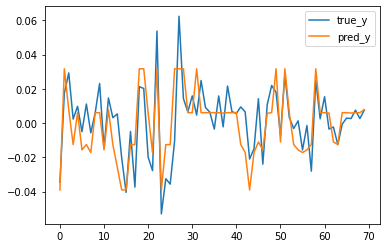

In [199]:
# true_y vs pred_v
true_y = y_test.values.ravel()
pred_y = best_model.predict(x_test.values)

train_result = mean_squared_error(best_model.predict(x_train.values), y_train.values.ravel())
test_result = mean_squared_error(true_y, pred_y)
print('train error:',train_result)
print('test error:',test_result)

from matplotlib import pyplot
pyplot.plot(true_y, label='true_y')
pyplot.plot(pred_y, label='pred_y')
pyplot.legend()
pyplot.savefig("abr_trueypredy.png")
pyplot.show()

In [200]:
#fAux - in sample
positions = np.where(grid_search.predict(x_train.values)> 0,1,-1 ) 
dailyRet = pd.Series(positions).shift(5).fillna(0).values * y_train['IVW_pred']
dailyRet = dailyRet.fillna(0)
cumret = np.array(np.cumprod(dailyRet + 1) - 1)

rho, pval = spearmanr(y_test,grid_search.predict(x_test.values)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret[-1]) ** ((253/5) / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = ((253/5) ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6} Rho={:0.6} PVal={:0.6}\n'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))



In-sample: CAGR=0.0453959 Sharpe ratio=0.420547 maxDD=-0.211603 maxDDD=223 Calmar ratio=0.214533 Rho=0.745078 PVal=1.40149e-13



In [201]:
#fAux - out of sample
positions2 = np.where(grid_search.predict(x_test.values)> 0,1,-1 )
dailyRet2 = pd.Series(positions2).shift(5).fillna(0).values * y_test['IVW_pred']
dailyRet2 = dailyRet2.fillna(0)
cumret2 = np.array(np.cumprod(dailyRet2 + 1) - 1)

rho, pval = spearmanr(y_test,grid_search.predict(x_test.values)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret2[-1]) ** ((253/5) / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = ((253/5) ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


Out-of-sample: CAGR=-0.0615213 Sharpe ratio=-0.390553 maxDD=-0.165233 maxDDD=48 Calmar ratio=-0.372331  Rho=0.745078 PVal=1.40149e-13



average return 0.208688
[-0.40776078  0.40538109]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.15900000000000003


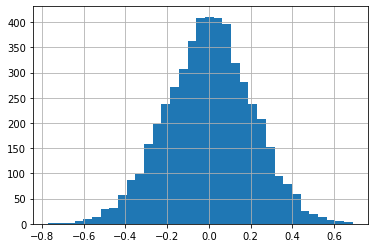

In [202]:
#white reality check

new_close = ivw_data.iloc[X.index.values]['Adj Close'].reset_index(drop= True)[(x_train.shape[0]):,]
detrended_close = detrendPrice.detrendPrice(new_close)
detrended_ret1 = detrended_close.diff(5).shift(-5).fillna(0)
detrended_syst_rets = detrended_ret1 * pd.Series(positions).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
pyplot.savefig("abr_white.png")
pyplot.show()

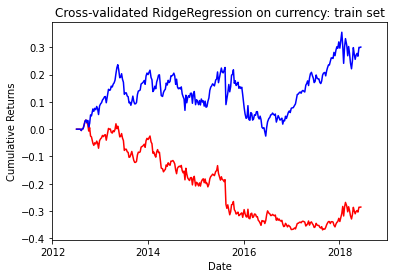

In [203]:
# equity curve - train
positionsytrain = np.where(y_train.values.ravel() > 0,1,-1 )
dailyRetytrain = pd.Series(positionsytrain).shift(5).fillna(0).values * y_train['IVW_pred']
dailyRetytrain = dailyRetytrain.fillna(0)
cumretytrain = np.array(np.cumprod(dailyRetytrain + 1) - 1)

df = ivw_data
dates = ivw_data.iloc[X.index.values]['Date']
dates= dates.reset_index(drop= True)[:x_train.shape[0],]

#x axis date formating
datesformat=[0 for _ in range(300)]
for i in range(300):
    datesformat[i] = pd.to_datetime(dates[i], format='%Y-%m-%d')
    
pyplot.figure(1)
pyplot.plot(datesformat, cumretytrain ,'r')
pyplot.plot(datesformat, cumret,'b')
    
myFmt = mdates.DateFormatter('%Y')
years = mdates.YearLocator(2)
months = mdates.MonthLocator()
pyplot.gca().xaxis.set_major_locator(years)
pyplot.gca().xaxis.set_major_formatter(myFmt)
datemin = np.datetime64('2012-01-01', 'Y')
datemax = np.datetime64('2019-01-01', 'Y')
pyplot.gca().set_xlim(datemin, datemax)

# plt.show()
pyplot.title('Cross-validated RidgeRegression on currency: train set')
pyplot.ylabel('Cumulative Returns')
pyplot.xlabel('Date')
pyplot.savefig("abr_cross_train.png")

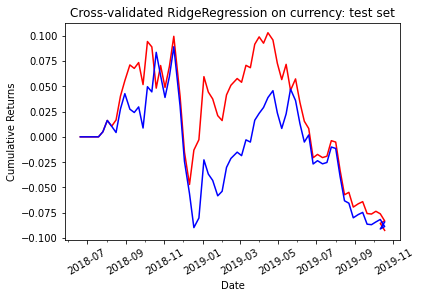

In [204]:
# equity curve - test
positionsytest = np.where(y_test.values.ravel() > 0,1,-1 )
dailyRetytest = pd.Series(positionsytest).shift(5).fillna(0).values * y_test['IVW_pred']
dailyRetytest = dailyRetytest.fillna(0)
cumretytest = np.array(np.cumprod(dailyRetytest + 1) - 1)

dates= df.iloc[X.index.values]['Date']
dates= dates.reset_index(drop= True)[x_train.shape[0]:,]

#x axis date formating
datesformat=[0 for _ in range(70)]
for i in range(70):
    datesformat[i] = pd.to_datetime(dates[i + 300], format='%Y-%m-%d')

pyplot.plot(datesformat, cumretytest ,'r')
pyplot.plot(datesformat, cumret2,'b')
    
myFmt = mdates.DateFormatter('%Y-%m')
years = mdates.YearLocator()
months = mdates.MonthLocator()
pyplot.gca().xaxis.set_major_formatter(myFmt)
pyplot.gca().xaxis.set_minor_locator(months)
pyplot.xticks(rotation=30)

pyplot.title('Cross-validated RidgeRegression on currency: test set')
pyplot.ylabel('Cumulative Returns')
pyplot.xlabel('Date')
pyplot.savefig("abr_cross_test.png")